In [1]:
import leaderbot as lb
import numpy
import numpy as np
import matplotlib.pyplot as plt
import texplot
import time
import scipy
import pickle

In [2]:
# Load form file instead
filename = '../benchmark/models_train_full.pkl'
#filename = '../benchmark/models_train_split.pkl'
with open(filename, 'rb') as f:
    results = pickle.load(f)

models = results['models']
names = np.array(results['data']['models'])

In [3]:
model = models[18-1]

rnk = model.rank()
scores = model.scores()

scores = scores[rnk]
names = names[rnk]

In [4]:
S = model._get_covariance(centered=False)
S = S[rnk, :][:, rnk]
# D = alg._distance_matrix()

n = S.shape[0]
d = np.array([np.diag(S)]).reshape(n, 1)
e = np.ones((n, 1))
D = d @ e.T + e @ d.T - 2.0 * S

D = np.zeros((n, n), dtype=float)
for i in range(n):
    for j in range(i+1, n):
        D[i, j] = (scores[i] - scores[j]) / np.sqrt(S[i, i] + S[j, j] - 2.0 * S[i, j])
        D[j, i] = D[i, j]

# max_rank = S.shape[0]
# S = S[rnk[:max_rank], :][:, rnk[:max_rank]]
# D = D[rnk[:max_rank], :][:, rnk[:max_rank]]

In [5]:
eig, V = numpy.linalg.eigh(S)
ind = numpy.argsort(eig)[::-1]
eig = eig[ind]
eig[numpy.abs(eig) < 1e-08] = 0
V = V[:, ind]
Z = numpy.diag(numpy.sqrt(eig))
W = V @ Z

In [6]:
m = 50

x = W[:m, 0]
y = W[:m, 1]
z = W[:m, 2]

colors = np.linspace(0, 1, m)
sizes = [5000 * (scores[i] - scores[m]) + 100*scores[m] for i in range(m)]

%matplotlib tk

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.set_proj_type('persp', focal_length=0.2)

ax.scatter(x, y, z, s=sizes, c=colors, cmap='turbo', alpha=0.9)

for i in range(m):
        ax.text(x[i], y[i], z[i], names[rnk[i]], fontsize=10, ha='left', va='center')

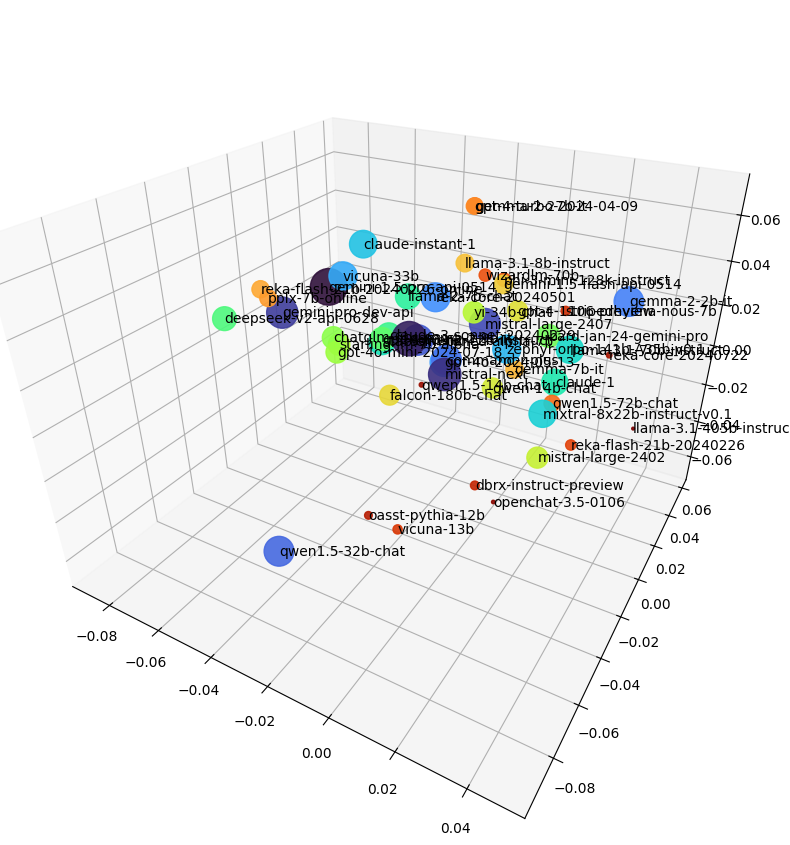

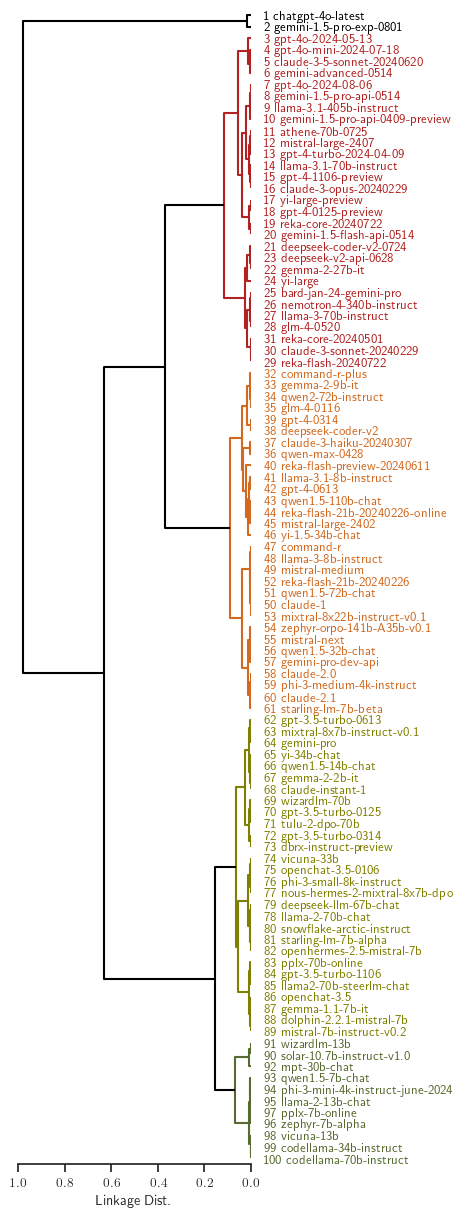

In [7]:
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import optimal_leaf_ordering, fcluster
from scipy.spatial.distance import squareform
from matplotlib.colors import to_rgba

m = 100

labels = []
for i in range(m):
    labels.append(f'{i+1:<3d} {names[i]:<20}')
labels = np.array(labels)
    
# labels = names[:m]
dist_matrix = D[:m, :][:, :m]

# Reverse orders
# labels = labels[::-1]
# dist_matrix = dist_matrix[::-1, :][:, ::-1]

dist_matrix_condensed = squareform(dist_matrix, checks=True)
linkage = sch.linkage(dist_matrix_condensed, method='complete',
                      optimal_ordering=True)
#linkage = sch.linkage(matrix, method='average', optimal_ordering=True)

# Compute optimal leaf ordering
linkage = optimal_leaf_ordering(linkage, dist_matrix_condensed)
# dendro = sch.dendrogram(ordered_linkage, no_plot=True)
# indices = dendro['leaves']
# #custom_order = np.r_[indices[:10], indices[20:], indices[10:20]]
# custom_order = indices
# print(custom_order)

# custom_linkage = sch.linkage(matrix[custom_order][:, custom_order], method='average')

# # Change the height of dendrogram to be a bit nicer
# y = custom_linkage[:, 2]
# custom_linkage[:, 2] = y / np.max(y)
# # z = y / np.max(y)

# # SETTING POWER TO LOWER VALUE MAKE THE DENDROGRAM HEIGHS MORE UNIFORMLY SPACED
# power = 1
linkage[:, 2] = linkage[:, 2] / (np.max(linkage[:, 2]) * 1.02)

# clusters = fcluster(linkage, t=3, criterion='maxclust')

%matplotlib inline

rc = {
    'font.family': 'sans-serif',
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage[utf8]{inputenc} \usepackage{amsmath} \usepackage{amsfonts} \usepackage{pifont}',
}

# Plot dendrogram with the custom order
# sch.set_link_color_palette(['darkgoldenrod', '#BF4E1A', 'maroon'])
#sch.set_link_color_palette(['darkgoldenrod', '#C24C00', 'maroon'])
with texplot.theme(use_latex=True, font_scale=0.85):

    plt.rcParams.update(rc)
    # fig, ax = plt.subplots(figsize=(12, 5))
    fig, ax = plt.subplots(figsize=(3, 15))
    colors = ['black', 'firebrick', '#EE6E00', 'darkgoldenrod', 'olivedrab']
    colors = ['black', 'firebrick', 'chocolate', 'darkgoldenrod', 'olivedrab']
    colors = ['black', 'firebrick', 'chocolate', 'olive', 'darkolivegreen']
    sch.set_link_color_palette(colors)
    dendro = sch.dendrogram(linkage, no_plot=False, labels=labels,
                            orientation='left', no_labels=False, color_threshold=0.15,
                            show_contracted=True, above_threshold_color='black', ax=ax,
                            leaf_rotation=0)

    label_colors = dendro['leaves_color_list']
    x_labels = ax.get_ymajorticklabels()  # Get y-axis labels for orientation 'left'
    for lbl, color in zip(x_labels, label_colors):
        lbl.set_color(color)

    # Get clusters based on threshold
    # clusters = sch.fcluster(linkage, t=0.15, criterion='distance')

    # main_colors = sns.color_palette("Set1", 4)
    
    # # Assign colors to each leaf and subgroup based on cluster
    # label_colors = []
    # for cluster_id in np.unique(clusters):
    #     # Choose a main color for the cluster
    #     main_color = to_rgba(main_colors[cluster_id % len(main_colors)])
        
    #     # Generate shades for each subgroup in the cluster
    #     sub_indices = np.where(clusters == cluster_id)[0]
    #     num_subgroups = len(sub_indices)
    #     sub_colors = sns.light_palette(main_color, num_subgroups, input="rgb") if num_subgroups > 1 else [main_color]
    
    #     # Append colors to label_colors for each subgroup
    #     for color in sub_colors:
    #         label_colors.append(color)
    
    # # Apply colors to y-axis labels based on dendrogram's ordering
    # x_labels = ax.get_ymajorticklabels()
    # for lbl, color in zip(x_labels, label_colors):
    #     lbl.set_color(color)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(False)  # Keep only the left spine (y-axis)
    # ax.get_xaxis().set_visible(False)
    
    #ax.set_ylim([0, 1])
    ax.set_xlim([0, 1])
    #ax.set_xlim([1e-3, 1])
    # ax.set_xscale('log')
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.set_xlabel('Linkage Dist.')
    # ax.set_ylabel('Linkage Dist.')
    # ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=9)
    # ax.xaxis.labelpad = 8
    ax.yaxis.labelpad = 8

    filename = 'cluster.pdf'
    plt.savefig(filename, bbox_inches='tight', pad_inches=0, transparent=True)

    plt.show()

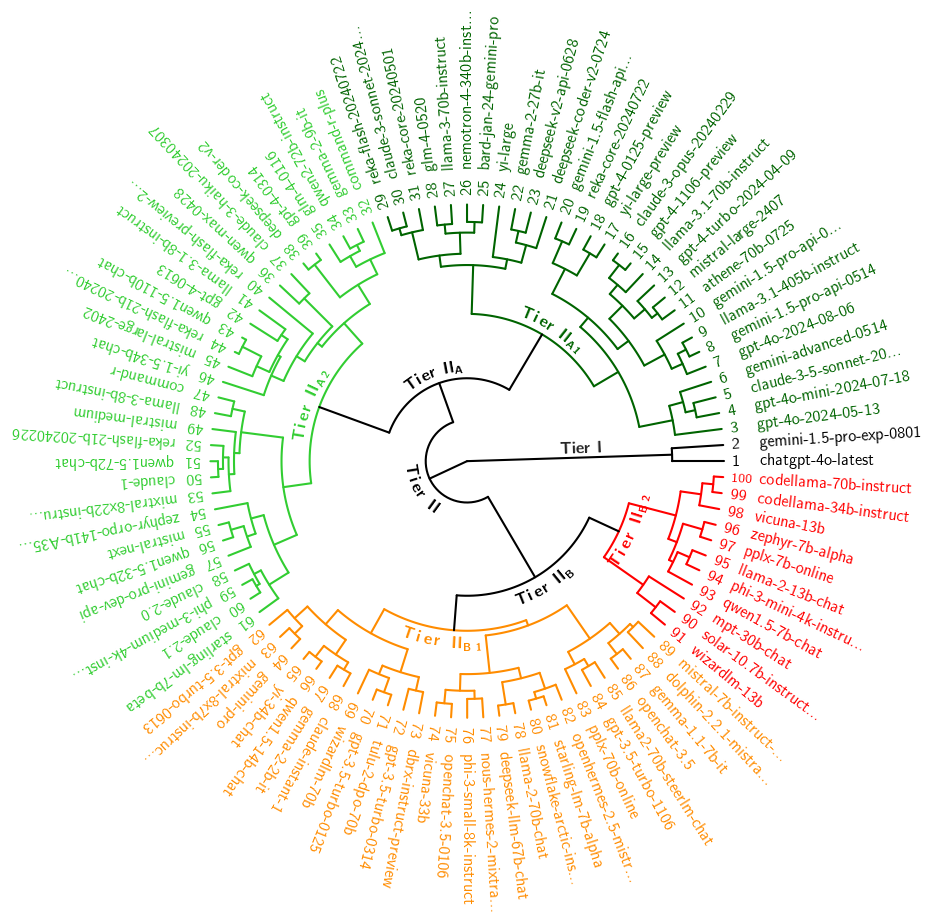

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Wedge

labels = []
for i in range(m):
    max_length = 23
    name = names[i]
    if len(name) > max_length:
        name = name[:max_length-3] + '...'
    # labels.append(f'{i+1:<3d} {name:>20}')
    labels.append(f'{name:>20}')
labels = np.array(labels)

dist_matrix_condensed = squareform(dist_matrix, checks=True)
linkage = sch.linkage(dist_matrix_condensed, method='complete',
                      optimal_ordering=True)
linkage = optimal_leaf_ordering(linkage, dist_matrix_condensed)

linkage[:, 2] = linkage[:, 2] / (np.max(linkage[:, 2]))

colors = ['black', 'firebrick', '#EE6E00', 'darkgoldenrod', 'olivedrab']
colors = ['black', 'firebrick', 'chocolate', 'darkgoldenrod', 'olivedrab']
colors = ['black', 'firebrick', 'chocolate', 'olive', 'darkolivegreen']
colors = ['black', 'red', 'darkorange', 'limegreen', 'darkgreen']
# colors = ['black', '#d93829', '#ff7f50', '#4caf50', '#1e5631']
colors = ['black', 'darkgreen', 'limegreen', 'darkorange', 'red']
#colors = ['#3b3b3b', '#e74c3c', '#ff8c42', '#6bbf59', '#216829']
# colors = ['#000000', '#8B0000', '#D04A1C', '#808000', '#3B5323']

sch.set_link_color_palette(colors)
dendro = sch.dendrogram(linkage, no_plot=True, labels=labels,
                            orientation='top', no_labels=False, color_threshold=0.15,
                            show_contracted=True, above_threshold_color='black',
                            leaf_rotation=0)
indices = dendro['leaves']

# Set up figure and polar axis
rc = {
    'font.family': 'sans-serif',
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{fixltx2e} \usepackage[utf8]{inputenc} \usepackage{amsmath} \usepackage{amsfonts} \usepackage{pifont}',
}

def curved_text(center_angle, radius, text, color, spacing=5, flip=False):
    if not isinstance(text, str):
        text_ = list(text)
    else:
        text_ = text
        
    tot_angle = float(spacing) * float(len(text_))
    if flip:
        start_angle = center_angle + tot_angle / 2.0
    else:
        start_angle = center_angle - tot_angle / 2.0
    for i, char in enumerate(text_):
        if flip:
            angle = start_angle - float(i) * spacing
            rot = angle - 90
        else:
            angle = start_angle + float(i) * spacing
            rot = angle + 90
        ax.text(np.radians(angle), radius, rf'\textbf{{{char}}}', ha='center', va='center', 
                rotation=rot, rotation_mode='anchor', color=color)

with texplot.theme(use_latex=True, font_scale=1):
    plt.rcParams.update(rc)
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': 'polar'})
    #ax.set_position([0.3, 0.3, 0.6, 0.6]) 
    
    # Calculate angles and distances for each branch
    num_leaves = len(dendro['ivl'])
    angles = np.linspace(0, 2 * np.pi, num_leaves, endpoint=False)
    
    # Define the radial scaling for 'dcoord' values to fit within the plot
    max_radius = max([max(sublist) for sublist in dendro['dcoord']])
    
    min_x, max_x = np.inf, -np.inf
    min_y, max_y = np.inf, -np.inf
    
    for i, (xs, ys) in enumerate(zip(dendro['icoord'], dendro['dcoord'])):
        xs = np.array(xs) / 10.0
        ys = np.array(ys)
        if min(xs) < min_x: min_x = min(xs)
        if max(xs) > max_x: max_x = max(xs)
        if min(ys) < min_y: min_y = min(ys)
        if max(ys) > max_y: max_y = max(ys)
    
    n_data = dist_matrix.shape[0]
    
    for i, (xs, ys) in enumerate(zip(dendro['icoord'], dendro['dcoord'])):
        xs = np.array(xs) / 10.0
        ys = (np.array(ys))**(0.4)
    
        t = (n_data / (n_data + 1)) * 2.0 * np.pi * (xs - min_x) / (max_x - min_x)
        r = (max_y - ys) / (max_y - min_y)
        
        # Draw the radial line segments
        t_rng = np.linspace(t[1], t[2], 40)
        r_rng = np.ones_like(t_rng) * r[1]
        ax.plot([t[0], t[1]], [r[0], r[1]], color=dendro['color_list'][i])
        ax.plot([t[2], t[3]], [r[2], r[3]], color=dendro['color_list'][i])
        ax.plot(t_rng, r_rng, color=dendro['color_list'][i])
    
    # Place labels around the circumference
    for index, angle, label, color in zip(indices, angles, dendro['ivl'], dendro['leaves_color_list']):
        if index + 1 == 100:
            ax.text(angle, 1.035, f'{index+1}', ha='left', va='center', rotation=np.degrees(angle),
                color=color, rotation_mode='anchor', fontsize=10)
        else:
            ax.text(angle, 1.035, f'{index+1}', ha='left', va='center', rotation=np.degrees(angle),
                    color=color, rotation_mode='anchor')
        ax.text(angle, 1.14, label, ha='left', va='center', rotation=np.degrees(angle),
                color=color, rotation_mode='anchor')

    # for angle, label, color in zip(angles, dendro['ivl'], dendro['leaves_color_list']):
    #     rotation = np.degrees(angle)
    #     # Flip text for angles between 90 and 270 degrees
    #     if 90 < rotation < 270:
    #         ax.text(angle, 1.05, label, ha='right', va='center', rotation=rotation + 180,
    #                 color=color, rotation_mode='anchor')
    #     else:
    #         ax.text(angle, 1.05, label, ha='left', va='center', rotation=rotation,
    #                 color=color, rotation_mode='anchor')

    ax.text(5 * 2*np.pi/360, 0.36, r'\textbf{Tier I', rotation=2)
    # ax.text(-144 * 2*np.pi/360, 0.325, r'\textbf{Tier II}', rotation=-63)
    # ax.text(128 * 2*np.pi/360, 0.37, r'\textbf{Tier II\textsubscript{A}}', rotation=19)
    # ax.text(-71 * 2*np.pi/360, 0.595, r'\textbf{Tier II\textsubscript{B}}', rotation=29)

    # ax.text(66 * 2*np.pi/360, 0.48, r'\textbf{Tier II\textsubscript{A\textsubscript{1}}}',
    #         rotation=-30, color=colors[1])
    # ax.text(172 * 2*np.pi/360, 0.69, r'\textbf{Tier II\textsubscript{A\textsubscript{2}}}',
    #         rotation=76, color=colors[2])
    # ax.text(-105 * 2*np.pi/360, 0.775, r'\textbf{Tier II\textsubscript{B\textsubscript{1}}}',
    #         rotation=-7, color=colors[3])
    # ax.text(-37 * 2*np.pi/360, 0.7, r'\textbf{Tier II\textsubscript{B\textsubscript{2}}}',
    #         rotation=65, color=colors[4])

    curved_text(-144, 0.22, list('Tier ') + ['II'], color='black', spacing=9)
    curved_text(108, 0.37, list('Tier ') + ['II'] + [r'\textsubscript{A}'], color='black',
                spacing=5, flip=True)
    curved_text(-56, 0.58, list('Tier ') + ['II'] + [r'\textsubscript{B}'], color='black',
                spacing=3.5, flip=False)
    curved_text(55, 0.62, list('Tier ') + ['II'] + [r'\textsubscript{A}'] + [r'\textsubscript{1}'],
                color=colors[1], spacing=3.2, flip=True)
    curved_text(158, 0.66, list('Tier ') + ['II'] + [r'\textsubscript{A}'] + [r'\textsubscript{2}'],
                color=colors[2], spacing=3.2, flip=True)
    curved_text(-96, 0.71, list('Tier ') + ['II'] + [r'\textsubscript{B}'] + [r'\textsubscript{1}'],
                color=colors[3], spacing=3.2, flip=False)
    curved_text(-21, 0.7, list('Tier ') + ['II'] + [r' \textsubscript{B}'] + [r'\textsubscript{2}'],
                color=colors[4], spacing=3.2, flip=False)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    ax.spines['polar'].set_visible(False)

    filename = 'cluster_circular.pdf'
    plt.savefig(filename, bbox_inches='tight', pad_inches=0, transparent=True)

    plt.show()